In [1]:
import numpy as np
import pandas as pd

# **DATA IMPORT**

In [2]:
# Preprocessing for topic modeling result
def tp_preprocessing(tp, type_check):
    tp_df = tp
    cn = tp_df['cmp']
    
    for i, val in enumerate(cn):
        if '(주)' in val:
            tmp = val.replace('(주)','')
            tp_df.loc[i,'cmp'] = tmp
    
    col_list = list(tp_df.columns)
    col_list[0] = 'company_name'
    for i in range(1, len(tp_df.columns)):
        if type_check == 'adv':
            col_list[i] = 'adv_topic ' + str(col_list[i])
        if type_check == 'dadv':
            col_list[i] = 'dadv_topic ' + str(col_list[i])
    tp_df.columns = col_list

    return tp_df

In [3]:
# Preprocessing for financial variable
def fv_preprocessing(fv):
  fv_df = fv
  afv = fv_df['average_salary']
  tfv = fv_df['total_sale']

  for i, val in enumerate(afv):
    if '만원' in val:
      tmp = int(val[:-2].replace(',',''))
      fv_df.loc[i,'average_salary'] = tmp
    if '회사' in val:
      fv_df.loc[i,'average_salary'] = np.NAN
    if '수집' in val:
      fv_df.loc[i,'average_salary'] = np.NAN


  for i, val in enumerate(tfv):
    if '조원' in val:
      tmp = float(val[:-2].replace(',',''))*1000
      fv_df.loc[i,'total_sale'] = tmp
    if '억원' in val:
      tmp = float(val[:-2].replace(',',''))
      fv_df.loc[i,'total_sale'] = tmp
    if '회사' in val:
      fv_df.loc[i,'total_sale'] = np.NAN


  
  return fv_df

In [4]:
# Preprocessing for turn over rate
def tor_preprocessing(tor):
  tor_df = tor
  tor_val = tor_df['turn_over_rate']

  for i, val in enumerate(tor_val):
    if '정보' in val:
      tor_df.loc[i,'turn_over_rate'] = np.NAN
    elif val == '(9999%)' :
      tor_df.loc[i,'turn_over_rate'] = np.NAN
    elif '(' in val:
      tmp = float(val[1:-1].replace('%',''))*0.01
      tor_df.loc[i,'turn_over_rate'] = tmp

  return tor_df

In [5]:
tp_adv = pd.read_csv("input/topic_modeling_result/bank_adv_topic_modeling.csv")
tp_dadv = pd.read_csv("input/topic_modeling_result/bank_dadv_topic_modeling.csv")

fv = pd.read_csv("input/financial_variable/bank_financial_financial_variable.csv")
tor = pd.read_csv("input/turn_over_rate/bank_financial_business_turn_over_rate.csv")

In [6]:
tp_adv = tp_adv.drop(['Unnamed: 0'], axis=1)
tp_adv = tp_preprocessing(tp_adv,'adv')
tp_dadv = tp_dadv.drop(['Unnamed: 0'], axis=1)
tp_dadv = tp_preprocessing(tp_dadv,'dadv')
fv = fv.drop(['Unnamed: 0'], axis=1)
fv = fv_preprocessing(fv)
tor = tor.drop(['Unnamed: 0'], axis=1)
tor = tor_preprocessing(tor)

In [7]:
df = pd.merge(tp_adv, tp_dadv, on = 'company_name', how = 'inner')
df = pd.merge(df, fv, on = 'company_name', how = 'inner')
df = pd.merge(df, tor, on = 'company_name', how = 'inner')
df = df.dropna()
df['average_salary'] = pd.to_numeric(df['average_salary'])
df['total_sale'] = pd.to_numeric(df['total_sale'])

# **MACHINE LEARNING MODEL**

In [8]:
# Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = df['turn_over_rate']
x_data = df.drop(['company_name','turn_over_rate'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_target, test_size = 0.3, random_state = 7)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE: {0: .3f}, RMSE : {1: .3F}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))


MSE:  0.039, RMSE :  0.196
Variance score : 0.089


In [9]:
from sklearn.model_selection import cross_val_score
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('#### ', model.__class__.__name__,'####')
    print('5 cv average RMSE : {0:.3f}'.format(avg_rmse))

In [10]:
# Various Types of Regressor Tree

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state= 7, max_depth=4)
rf_reg = RandomForestRegressor(random_state= 7, n_estimators= 1000)
gb_reg = GradientBoostingRegressor(random_state= 7, n_estimators= 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model,x_data, y_target.astype('float64'))

####  DecisionTreeRegressor ####
5 cv average RMSE : 0.214
####  RandomForestRegressor ####
5 cv average RMSE : 0.150
####  GradientBoostingRegressor ####
5 cv average RMSE : 0.167
####  XGBRegressor ####
5 cv average RMSE : 0.182
####  LGBMRegressor ####
5 cv average RMSE : 0.188


<Axes: >

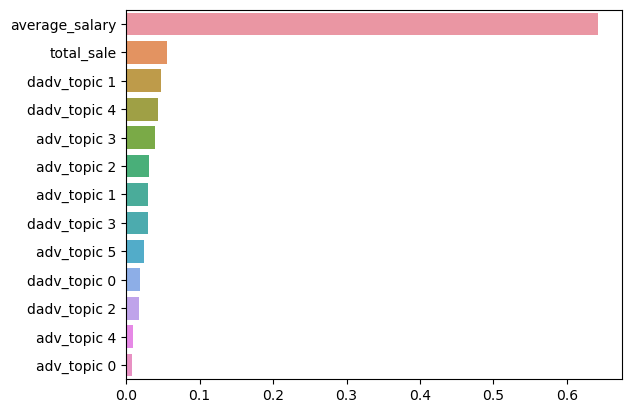

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

rf_reg = RandomForestRegressor(n_estimators=1000)

rf_reg.fit(x_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index =x_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y= feature_series.index)
